# Stop visualization EDA

#### Stop lookup api

In [1]:
from dotenv import load_dotenv
import os
import requests


load_dotenv()


API_KEY = os.getenv("API_KEY")

url = f"https://api.resrobot.se/v2.1/location.name?input=Göteborg&format=json&accessId={API_KEY}"

response = requests.get(url)

response


<Response [200]>

In [2]:
data = response.json()

print(data.keys())

dict_keys(['stopLocationOrCoordLocation', 'TechnicalMessages', 'serverVersion', 'dialectVersion', 'requestId'])


In [3]:
# 'stopLocationOrCoordLocation'
stops_data = data.get("stopLocationOrCoordLocation", [])
stops_data[:5] 


[{'StopLocation': {'productAtStop': [{'icon': {'res': 'prod_gen'}, 'cls': '2'},
    {'icon': {'res': 'prod_gen'}, 'cls': '4'},
    {'icon': {'res': 'prod_gen'}, 'cls': '8'},
    {'icon': {'res': 'prod_gen'}, 'cls': '16'},
    {'icon': {'res': 'prod_gen'}, 'cls': '64'},
    {'icon': {'res': 'prod_gen'}, 'cls': '128'},
    {'icon': {'res': 'prod_gen'}, 'cls': '256'}],
   'timezoneOffset': 60,
   'id': 'A=1@O=GÖTEBORG@X=11973479@Y=57708895@U=1@L=740098001@B=1@p=1737434182@',
   'extId': '740098001',
   'name': 'GÖTEBORG',
   'lon': 11.973479,
   'lat': 57.708895,
   'weight': 15426,
   'products': 222,
   'meta': True,
   'minimumChangeDuration': 'PT26M'}},
 {'StopLocation': {'productAtStop': [{'icon': {'res': 'prod_gen'}, 'cls': '2'},
    {'icon': {'res': 'prod_gen'}, 'cls': '4'},
    {'icon': {'res': 'prod_gen'}, 'cls': '8'},
    {'icon': {'res': 'prod_gen'}, 'cls': '16'},
    {'icon': {'res': 'prod_gen'}, 'cls': '64'},
    {'icon': {'res': 'prod_gen'}, 'cls': '128'}],
   'timezoneOffse

In [4]:
from backend.connect_to_api import ResRobot  
import pandas as pd


resrobot = ResRobot()


location = "Göteborg"
stops = resrobot.access_id_from_location(location)


df_stops = pd.DataFrame(stops)


print(df_stops.head())

# verkar inte gå att få alla hållplatser inom visa koordinater med denna api:n får testa en annan. Denna api:n tar bara hållplatser baserat på namn input.


Name                                               extId
GÖTEBORG                                           740098001
Göteborg Centralstation                            740000002
Göteborg Sävenäs lokstation                        740016365
GÖTEBORG GAMLESTADEN                               740098526
Göteborg Korsvägen                                 740015578
Göteborg Kungsportsplatsen                         740016358
Göteborg Stenpiren                                 740072430
Göteborg Eketrägatan                               740025624
Göteborg Vårväderstorget                           740025707
Göteborg Axel Dahlströms torg                      740025608
Empty DataFrame
Columns: []
Index: []


# Nearby stop api


In [5]:

url = f"https://api.resrobot.se/v2.1/location.nearbystops?originCoordLat=57.708895&originCoordLong=11.973479&format=json&accessId={API_KEY}"

response = requests.get(url)

response

<Response [200]>

In [6]:
data = response.json()  
data.keys() 

dict_keys(['stopLocationOrCoordLocation', 'TechnicalMessages', 'serverVersion', 'dialectVersion', 'requestId'])

In [7]:
stops_data = data.get("stopLocationOrCoordLocation", [])

stops_data

''' Varje objekt innehåller en "stoplocation" med fält som name, lon och lat, products(typ av transport), dist(avstånd till punkten?!) och extId(unik identifierare)'''

' Varje objekt innehåller en "stoplocation" med fält som name, lon och lat, products(typ av transport), dist(avstånd till punkten?!) och extId(unik identifierare)'

In [8]:
# Extrahera data från 'StopLocation'
stops = [
    {
        "name": stop["StopLocation"]["name"],
        "lat": stop["StopLocation"]["lat"],
        "lon": stop["StopLocation"]["lon"],
        "dist": stop["StopLocation"]["dist"],
        "products": stop["StopLocation"]["products"],
    }
    for stop in stops_data
]


df = pd.DataFrame(stops)


print(df.head())


                            name        lat        lon  dist  products
0        Göteborg Centralstation  57.708895  11.973479     0       150
1  Göteborg Centralst Drottningt  57.707898  11.973740   112       192
2          Göteborg Åkareplatsen  57.708329  11.975942   159       136
3              Göteborg Nordstan  57.709246  11.970791   164       192
4  Göteborg Nils Ericsonterminal  57.710271  11.971852   180       136


products bitmask förklaring 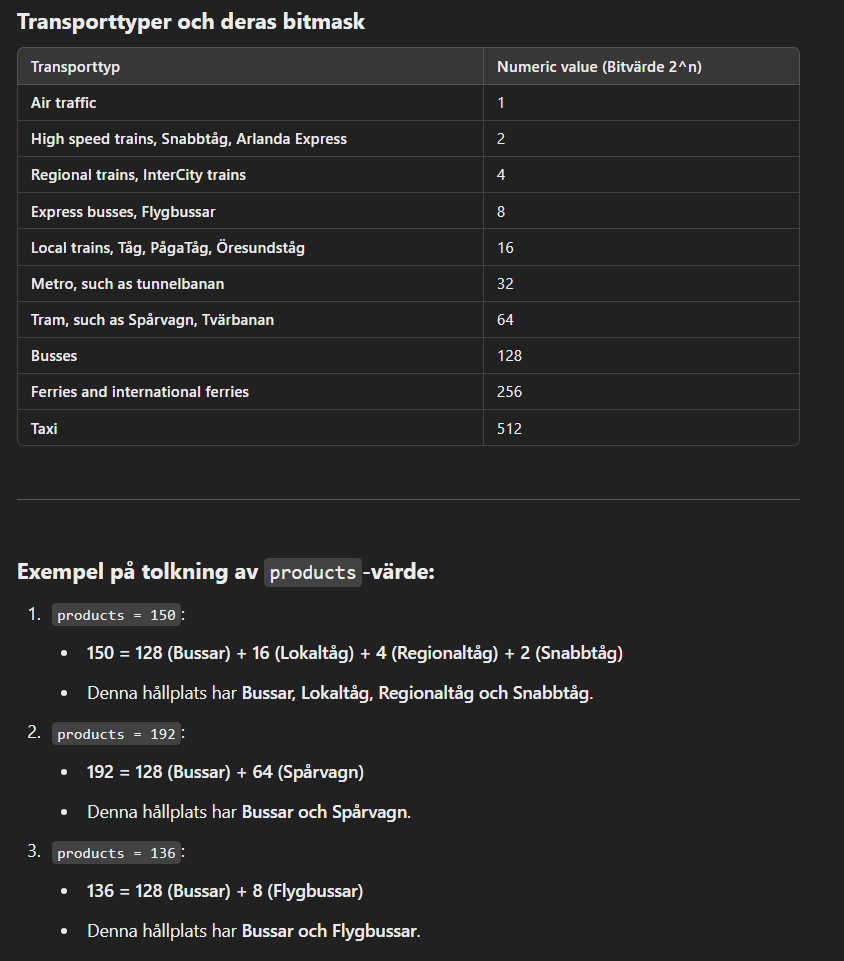

In [9]:

resrobot = ResRobot()


location = "Göteborg Centralstation"
resrobot.access_id_from_location(location)


Name                                               extId
Göteborg Centralstation                            740000002
Göteborg Centralst Drottningt                      740030117
Göteborg Sävenäs lokstation                        740016365
Trelleborg Centralstation                          740000088
Helsingborg Centralstation                         740000044
Gamlestaden station (Göteborg kn)                  740001590
Vänersborg Centralstation                          740000241
Liseberg station (Göteborg kn)                     740001230
Säve station (Göteborg kn)                         740015599
Askim Stationsväg (Göteborg kn)                    740059091


In [10]:
def get_coordinates_from_extid(ext_id):
    url = f"https://api.resrobot.se/v2.1/location.name?input={ext_id}&format=json&accessId={API_KEY}"
    result = requests.get(url).json()
    
    return next(
        (
            {
                "name": stop_data.get("name"),
                "lat": stop_data.get("lat"),
                "lon": stop_data.get("lon")
            }
            for stop in result.get("stopLocationOrCoordLocation", [])
            for stop_data in [next(iter(stop.values()))]
        ), None)


ext_id = 740000002  
coordinates = get_coordinates_from_extid(ext_id)
print(coordinates)  



{'name': 'Göteborg Centralstation', 'lat': 57.708895, 'lon': 11.973479}


In [ ]:
# Visar koordinaterna på en foliumkarta

import folium

map_nearby_stops = folium.Map(location=[coordinates["lat"], coordinates["lon"]], zoom_start=14)

folium.Marker(location=[coordinates["lat"], coordinates["lon"]],
    popup=f"{coordinates['name']}",
    icon=folium.Icon(color="blue", icon="info-sign")).add_to(map_nearby_stops)

map_nearby_stops